In [1]:
from idaes import __version__

if '2.0.0.a3' not in __version__:
    raise EnvironmentError("This notebook requires the 2.0.0.a3 pre-release of idaes-pse, which can be found here: https://github.com/dguittet/idaes-pse/tree/2.0.0.a3")

from wind_battery_double_loop import MultiPeriodWindBattery
from dispatches_sample_data import rts_gmlc
from double_loop_utils import *

## Creating the Co-simulation of the Wind and Battery IES within the Production Cost Model with Bidder and Tracker Models

In the [Conceptual Design Optimization Example Notebook](./ConceptualDesignOptimization.ipynb), the design of a Wind + Battery + Hydrogen integrated energy system was optimized using the RTS-GMLC outputs with a "price taker" assumption. Here, we take one of the possible results, a Wind + Battery IES with no Hydrogen, and evaluate its performance in an electricity market by co-simulating its bidding and operation decisions within the production cost model, Prescient, in a "double-loop" optimization.

This double-loop is performed by embedding the multiperiod Wind + Battery flowsheet model as a `MultiPeriodWindBattery` within a `Bidder` and a `Tracker` model, whose functions are to optimize the Day-ahead or Real-time energy market bids, and to optimize the operation of the IES to follow the cleared market's dispatch, respectively. These functions are coordinated in order and with the correct data transfers with Prescient by a `DoubleLoopCoordinator` class. Prescient is then able to evaluate the economic performance of the designed IES within the grid with market interactions and forecast uncertainty. The steps are as shown in this diagram:

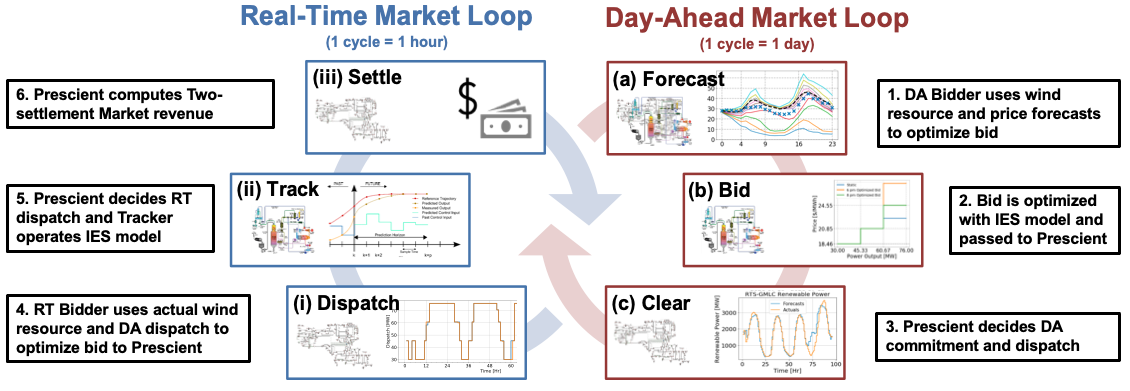

In the Day-ahead loop, the Unit Commitment Problem is solved by forecasting loads and obtaining generator bids, and produces hourly schedules and LMPs. The `Bidder` will use forecasts and plant information to optimize the DA bid to Prescient.

In the Real-time loop, the Economic Dispatch Problem is solved using real-time loads and resources to produce updated generator dispatch points and commitments. The `Bidder` will use forecasts, DA dispatch and prices, and plant information to optimize the updated RT bid. Once the Real-time market is cleared, the `Tracker` controls the IES to implement the dispatch at lowest cost. 

The market participants are paid on energy and/or reserve provided based on the two-settlement system:

$$R = Q_{DA} \times P_{DA} + (Q_{RT} - Q_{DA}) \times P_{RT}$$

where $R$ is revenue, $Q_{DA}$ is power sold to DA market at $P_{DA}$ price, and $Q_{RT}$ is power delivered to RT market at $P_{RT}$ price.

First, we define the electricity grid for the double-loop simulation via options to Prescient: the directory to the RTS-GMLC source data, the time horizons for the UC and ED problems, the start date and length of the simulation, how much reserves should be procured, etc. The full-year PCM simulation was completed prior and the outputs were collected into a `Wind_Thermal_Dispatch.csv` in order to provide "historical" LMPs and Wind resource capacity factors for the Conceptual Design Optimization.

In this example, we will repeat the Prescient simulation for a single day with no reserves, where the Wind + Battery IES will replace the `309_WIND_1` Wind plant at the "Carter" bus.

In [47]:
from prescient.simulator import Prescient
import os

start_date = "01-02-2020"
day_ahead_horizon = 48
real_time_horizon = 4
output_dir = Path(f"double_loop_results")

wind_bus = 309
wind_bus_name = "Carter"
wind_generator = f"{wind_bus}_WIND_1"

milp_solver = 'xpress_direct'

prescient_options = {
    "data_path": rts_gmlc.source_data_path,
    "input_format": "rts-gmlc",
    "simulate_out_of_sample": True,
    "run_sced_with_persistent_forecast_errors": True,
    "output_directory": output_dir,
    "start_date": start_date,
    "num_days": 1,
    "sced_horizon": real_time_horizon,
    "ruc_horizon": day_ahead_horizon,
    "compute_market_settlements": True,
    "day_ahead_pricing": "LMP",
    "ruc_mipgap": 0.05,
    "symbolic_solver_labels": True,
    "reserve_factor": 0,
    "deterministic_ruc_solver": milp_solver,
    "sced_solver": milp_solver,
    "plugin": {
        "doubleloop": {
            "module": None,                                          # to be added below
            "bidding_generator": wind_generator,
        }
    }
}

# collect "historical" full-year wind forecast and first-day LMPs
prescient_outputs_df = pd.read_csv(Path(os.path.realpath("__file__")).parent / "data" / "Wind_Thermal_Dispatch.csv")
prescient_outputs_df.index = pd.to_datetime(prescient_outputs_df['Unnamed: 0'])
prescient_outputs_df = prescient_outputs_df[prescient_outputs_df.index >= pd.Timestamp(f'{start_date} 00:00:00')]
gen_capacity_factor = prescient_outputs_df[f"{wind_generator}-RTCF"].values.tolist()
historical_da_prices = {
    wind_bus_name: prescient_outputs_df[f"{wind_bus}_DALMP"].values[0:24].tolist()
}
historical_rt_prices = {
    wind_bus_name: prescient_outputs_df[f"{wind_bus}_RTLMP"].values[0:24].tolist()
}

## Creating the IES Generator within the RTS-GMLC

First, the location, type, capacity, and other parameters of the IES needs to be defined in order to situate the generator within the electricity market. In this example, the IES' bid will be represented as that of a thermal generator, with parameters such as min power, max power, ramping constraints, startup and shutdown capacity, even though the IES will not need them all. The wind resource at the chosen location, at the "Carter" bus, is read from the RTS-GMLC Source Data.

The information is passed to the `MultiPeriodWindBattery` class, which enables the `Bidder` and `Tracker` to construct a Wind + Battery multiperiod model within its bidding and tracking optimization problems via `populate_model`, and to update the state of the Wind + Battery IES as the double-loop steps forward in time via `update_model`.

In [32]:
from idaes.apps.grid_integration.model_data import ThermalGeneratorModelData

p_min = 0
wind_pmax = 200
battery_pmax = 143
battery_emax = battery_pmax * 4

# for descriptions on what each parameter means, see `help(ThermalGeneratorModelData)`
thermal_generator_params = {
    "gen_name": wind_generator,
    "bus": wind_bus_name,
    "p_min": p_min,
    "p_max": wind_pmax,
    "min_down_time": 0,
    "min_up_time": 0,
    "ramp_up_60min": wind_pmax + battery_pmax,
    "ramp_down_60min": wind_pmax + battery_pmax,
    "shutdown_capacity": wind_pmax + battery_pmax,
    "startup_capacity": 0,
    "initial_status": 1,
    "initial_p_output": 0,
    "production_cost_bid_pairs": [(p_min, 0), (wind_pmax, 0)],
    "startup_cost_pairs": [(0, 0)],
    "fixed_commitment": None,
}
model_data = ThermalGeneratorModelData(**thermal_generator_params)

mp_wind_battery_bid = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

## Creating the Forecaster, Tracker, and Bidder for the DoupleLoopCoordinator

The `Bidder` requires a forecast of the DA and RT prices in order to plan out its energy bid: at what time to sell how much energy and at what price, given the anticipated wind resource and the evolution of the battery state-of-charge. In contrast to the price-taker assumption in the Conceptual Design phase where the Wind + Battery IES took the historical LMPs for however much energy it sold, here, the `Bidder` does not know what the final LMP will be, nor that its bid for energy at a certain marginal cost will be accepted by the market. 

The `Backcaster` class stores historical DA and RT LMPs in order to generate forecast scenarios. The first day of simulated DA and RT LMPs initializes the `Backcaster`, which continues to collect resolved LMPs as the simulation steps forward in time. 

Within the `DoubleLoopCoordinator`, there are two `Tracker` objects, the first `tracker` follows the real-time market signals whereas the second `projection_tracker` projects the latest real-time dispatch onto the next day-ahead bidding problem. 

In [53]:
import pyomo.environ as pyo
from idaes.apps.grid_integration.forecaster import Backcaster
from idaes.apps.grid_integration import Tracker, DoubleLoopCoordinator, Bidder

# Backcaster
help(Backcaster)
backcaster = Backcaster(historical_da_prices, historical_rt_prices)

Help on class Backcaster in module idaes.apps.grid_integration.forecaster:

class Backcaster(AbstractPrescientPriceForecaster)
 |  Backcaster(historical_da_prices, historical_rt_prices, max_historical_days=10)
 |  
 |  Generate price forecasts by directly using historical prices.
 |  
 |  Method resolution order:
 |      Backcaster
 |      AbstractPrescientPriceForecaster
 |      AbstractPriceForecaster
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, historical_da_prices, historical_rt_prices, max_historical_days=10)
 |      Initialize the Backcaster.
 |      
 |      Arguments:
 |          historical_da_prices: dictionary of list for historical hourly day-ahead prices
 |      
 |          historical_rt_prices: dictionary of list for historical hourly real-time prices
 |      
 |          max_historical_days: maximum number of days of price data to store on the instance
 |      
 |      Returns:
 |          None
 |  
 |  fetch_day_ahead_st

In [55]:
n_price_scenario = 3
solver = pyo.SolverFactory(milp_solver)

# Bidder
help(Bidder)
bidder_mp_wind_battery = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

bidder_object = Bidder(
    bidding_model_object=bidder_mp_wind_battery,
    day_ahead_horizon=day_ahead_horizon,
    real_time_horizon=real_time_horizon,
    n_scenario=n_price_scenario,
    solver=solver,
    forecaster=backcaster,
)

Help on class Bidder in module idaes.apps.grid_integration.bidder:

class Bidder(StochasticProgramBidder)
 |  Bidder(bidding_model_object, day_ahead_horizon, real_time_horizon, n_scenario, solver, forecaster)
 |  
 |  Wrap a model object to bid into the market using stochastic programming.
 |  
 |  Method resolution order:
 |      Bidder
 |      StochasticProgramBidder
 |      AbstractBidder
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, bidding_model_object, day_ahead_horizon, real_time_horizon, n_scenario, solver, forecaster)
 |      Initializes the bidder object.
 |      
 |      Arguments:
 |          bidding_model_object: the model object for bidding
 |      
 |          day_ahead_horizon: number of time periods in the day-ahead bidding problem
 |      
 |          real_time_horizon: number of time periods in the real-time bidding problem
 |      
 |          n_scenario: number of uncertain LMP scenarios
 |      
 |          solver: 

In [58]:
tracking_horizon = 4
n_tracking_hour = 1

# Tracker
help(Tracker)
tracker_mp_wind_battery = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

tracker_object = Tracker(
    tracking_model_object=tracker_mp_wind_battery,
    tracking_horizon=tracking_horizon,
    n_tracking_hour=n_tracking_hour,
    solver=solver,
)

# Projection Tracker
projection_mp_wind_battery = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

projection_tracker_object = Tracker(
    tracking_model_object=projection_mp_wind_battery,
    tracking_horizon=tracking_horizon,
    n_tracking_hour=n_tracking_hour,
    solver=solver,
)

Help on class Tracker in module idaes.apps.grid_integration.tracker:

class Tracker(builtins.object)
 |  Tracker(tracking_model_object, tracking_horizon, n_tracking_hour, solver)
 |  
 |  Wrap a model object to track the market dispatch signals. This class interfaces
 |  with the DoubleLoopCoordinator.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, tracking_model_object, tracking_horizon, n_tracking_hour, solver)
 |      Initializes the tracker object.
 |      
 |      Arguments:
 |          tracking_model_object: the model object for tracking
 |      
 |          tracking_horizon: number of time periods in the tracking problem
 |      
 |          n_tracking_hour: number of implemented hours after each solve
 |      
 |          solver: a Pyomo mathematical programming solver object
 |      
 |      Returns:
 |          None
 |  
 |  formulate_tracking_problem(self)
 |      Formulate the tracking optimization problem by adding necessary
 |      parameters, constraints, and obj

In [57]:
# Compose into Coordinator
help(DoubleLoopCoordinator)
coordinator = DoubleLoopCoordinator(
    bidder=bidder_object,
    tracker=tracker_object,
    projection_tracker=projection_tracker_object,
)

Help on class DoubleLoopCoordinator in module idaes.apps.grid_integration.coordinator:

class DoubleLoopCoordinator(builtins.object)
 |  DoubleLoopCoordinator(bidder, tracker, projection_tracker)
 |  
 |  Coordinate Prescient, tracker and bidder.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, bidder, tracker, projection_tracker)
 |      Initializes the DoubleLoopCoordinator object and registers functionalities
 |      in Prescient's plugin system.
 |      
 |      Arguments:
 |          bidder: an initialized bidder object
 |      
 |          tracker: an initialized bidder object
 |      
 |          projection_tracker: an initialized bidder object, this object is
 |                              mimicking the behaviro of the projection SCED in
 |                              Prescient and to projecting the system states
 |                              and updating bidder model.
 |      
 |      Returns:
 |          None
 |  
 |  activate_pending_DA_data(self, options, simulato

## Running the Double-Loop Plugin

The prescient_options are updated with the DoubleLoopCoordinator. The simulation results will be written to the `output_dir` folder.

In [40]:
from types import ModuleType

class PrescientPluginModule(ModuleType):
    def __init__(self, get_configuration, register_plugins):
        self.get_configuration = get_configuration
        self.register_plugins = register_plugins


plugin_module = PrescientPluginModule(
    get_configuration=coordinator.get_configuration,
    register_plugins=coordinator.register_plugins,
)

prescient_options['plugin']['doubleloop']['module'] = plugin_module

Prescient().simulate(**prescient_options)

Initializing simulation...
Did not find reserves.csv; assuming no reserves


/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/pandas/io/parsers/base_parser.py:1055: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


Setting default t0 state in RTS-GMLC parser
Dates to simulate: 2020-01-02 to 2020-01-02
RUC activation hours: 0
Final RUC date: 2020-01-02
Using current day's forecasts for RUC solves
Using persistent forecast error model when projecting demand and renewables in SCED


Extracting scenario to simulate
FICO Xpress v8.12.4, Hyper, solve started 14:18:42, Jul 3, 2022
Heap usage: 1540KB (peak 1540KB, 1449KB system)
Maximizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
      2586 rows         2016 cols         4443 elements
Presolved problem has:
       429 rows          576 cols         1431 elements
Presolve finished in 0 seconds
Heap usage: 1574KB (peak 2983KB, 1451KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 1.05e+03,  1.00e+08] / [ 1.05e+03,  8.00e+08]
  Objective      [min,max] : [ 1.50e-02,  1.89e+01] /


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 14:21:40, Jul 3, 2022
Heap usage: 362KB (peak 362KB, 2791KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2794KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 5.64e+02,  1.00e+08] / [ 5.35e+02,  5.86e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       4169.354664      D      4     0        .000000     0
     4       4780.868488      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 14:21:46, Jul 3, 2022
Heap usage: 362KB (peak 362KB, 2819KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2822KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 4.43e+03,  1.00e+08] / [ 2.21e+03,  5.86e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       3960.150348      D      4     0        .000000     0
     4       4337.257564      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 14:21:52, Jul 3, 2022
Heap usage: 362KB (peak 362KB, 2847KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2850KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 1.25e+03,  1.00e+08] / [ 6.24e+02,  5.86e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       3936.296673      D      4     0        .000000     0
     4       3989.735649      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 14:21:58, Jul 3, 2022
Heap usage: 362KB (peak 362KB, 2876KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2878KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 1.05e+03,  1.00e+08] / [ 6.57e+02,  5.86e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       3936.802405      D      4     0        .000000     0
     4       3963.016162      D    


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 14:22:05, Jul 3, 2022
Heap usage: 362KB (peak 362KB, 2906KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
        11 rows           18 cols           39 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2908KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 2.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 2.44e+00,  1.00e+08] / [ 3.12e+02,  5.86e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 2.40e-01,  3.91e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       3941.101122      D      4     0        .000000     0
     6       3960.159722      D    


User solution (_) stored.

Solving for LMPs


User solution (_) stored.

FICO Xpress v8.12.4, Hyper, solve started 14:22:14, Jul 3, 2022
Heap usage: 362KB (peak 362KB, 3232KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 3234KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 1.37e+03,  1.00e+08] / [ 1.37e+03,  5.86e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       4081.020206      D      4     0   


Solving for LMPs


User solution (_) stored.

FICO Xpress v8.12.4, Hyper, solve started 14:22:22, Jul 3, 2022
Heap usage: 362KB (peak 362KB, 3038KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        62 rows           60 cols          120 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 3040KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 2.05e+04,  1.00e+08] / [ 2.05e+04,  5.86e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.20e-01,  2.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 2 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       4635.807799      D      4     0        .000000     0
     4  


Solving for LMPs


FICO Xpress v8.12.4, Hyper, solve started 14:22:28, Jul 3, 2022
Heap usage: 362KB (peak 362KB, 2778KB system)
Minimizing LP unknown with these control settings:
OUTPUTLOG = 1
Original problem has:
        59 rows           60 cols          108 elements
Presolved problem has:
         9 rows           14 cols           32 elements
Presolve finished in 0 seconds
Heap usage: 361KB (peak 402KB, 2780KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e-04,  1.05e+00] / [ 1.56e-02,  1.60e+01]
  RHS and bounds [min,max] : [ 4.40e+04,  1.00e+08] / [ 3.12e+04,  5.86e+08]
  Objective      [min,max] : [ 1.50e-02,  1.00e+04] / [ 1.50e-02,  1.00e+01]
Autoscaling applied Curtis-Reid scaling

Crash basis containing 3 structural columns created
 
   Its         Obj Value      S   Ninf  Nneg   Sum Dual Inf  Time
     0       3926.940638      D      4     0        .000000     0
     5       4635.807800      D    

## Analyzing the Wind + Battery IES Performance

Lots of stuff happens of course

In [41]:
df = double_loop_outputs_for_gen(output_dir, rts_gmlc.source_data_path)

In [44]:
df[df['Model'] == "Prescient"]

,Horizon [hr],Model,DA Power 0 [MW],DA Cost 0 [$],RT Power 0 [MW],RT Cost 0 [$],Power Dispatch [MW],Power Output [MW],Power Underdelivered [MW],Power Overdelivered [MW],...,Bus,Demand,Shortfall,Overgeneration,LMP,LMP DA,309_WIND_1-RTPower,309_WIND_1-DAPower,309_WIND_1-RTCF,309_WIND_1-DACF
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00,NaN,Prescient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Carter,78.251809,0.0,0.0,21.647258,20.400003,0.833333,0.1,0.005619,0.000674
2020-01-02 01:00:00,NaN,Prescient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Carter,74.178201,0.0,0.0,23.437807,19.430296,1.166667,0.8,0.007867,0.005394
2020-01-02 02:00:00,NaN,Prescient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Carter,71.701007,0.0,0.0,23.437807,19.689430,15.208333,2.7,0.102551,0.018206
2020-01-02 03:00:00,NaN,Prescient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Carter,69.884398,0.0,0.0,23.657594,19.983547,19.233333,11.4,0.129692,0.076871
2020-01-02 04:00:00,NaN,Prescient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Carter,68.810947,0.0,0.0,23.437807,20.419098,26.016667,18.3,0.175433,0.123399
2020-01-02 05:00:00,NaN,Prescient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Carter,70.324788,0.0,0.0,21.287879,21.647258,23.966667,23.6,0.161609,0.159137
2020-01-02 06:00:00,NaN,Prescient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Carter,78.554577,0.0,0.0,22.968160,23.069973,8.841667,24.6,0.059620,0.165880
2020-01-02 07:00:00,NaN,Prescient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Carter,84.830135,0.0,0.0,23.069973,-0.000000,4.475000,10.3,0.030175,0.069454
2020-01-02 08:00:00,NaN,Prescient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Carter,91.023121,0.0,0.0,16.970947,-0.000000,3.283333,5.6,0.022140,0.037761


Help on class DoubleLoopCoordinator in module idaes.apps.grid_integration.coordinator:

class DoubleLoopCoordinator(builtins.object)
 |  DoubleLoopCoordinator(bidder, tracker, projection_tracker)
 |  
 |  Coordinate Prescient, tracker and bidder.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, bidder, tracker, projection_tracker)
 |      Initializes the DoubleLoopCoordinator object and registers functionalities
 |      in Prescient's plugin system.
 |      
 |      Arguments:
 |          bidder: an initialized bidder object
 |      
 |          tracker: an initialized bidder object
 |      
 |          projection_tracker: an initialized bidder object, this object is
 |                              mimicking the behaviro of the projection SCED in
 |                              Prescient and to projecting the system states
 |                              and updating bidder model.
 |      
 |      Returns:
 |          None
 |  
 |  activate_pending_DA_data(self, options, simulato